# LucidBench Benchmark Analysis

This notebook provides comprehensive analysis of filesystem benchmark results across different storage devices and filesystems.

## Table of Contents
1. [Setup and Data Loading](#setup)
2. [Overview and Summary Statistics](#overview)
3. [Performance Analysis by Storage Type](#storage-analysis)
4. [Filesystem Comparison](#filesystem-analysis)
5. [I/O Pattern Analysis](#io-analysis)
6. [Resource Utilization](#resource-analysis)
7. [Statistical Analysis](#statistical-analysis)
8. [Comparative Analysis](#comparative-analysis)
9. [Recommendations and Conclusions](#conclusions)

## 1. Setup and Data Loading <a name="setup"></a>

In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy import stats
from pathlib import Path

# Set plot style
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')

# Configure display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)

In [3]:
def load_benchmark_data(run_dir):
    """Load all benchmark and monitoring data from a run directory."""
    data = []
    
    for test_dir in Path(run_dir).glob('*'):
        if not test_dir.is_dir():
            continue
            
        # Parse test directory name
        parts = test_dir.name.split('_')
        if len(parts) < 4:
            continue
            
        storage_type = parts[0]
        device = parts[1]
        filesystem = parts[2]
        test_type = '_'.join(parts[3:])
        
        # Load test data
        test_file = test_dir / 'test.json'
        if test_file.exists():
            with open(test_file) as f:
                content = f.read()
                start_idx = content.find('{')
                if start_idx >= 0:
                    test_data = json.loads(content[start_idx:])
                else:
                    test_data = json.loads(content)
                
                # Load monitoring data
                monitor_file = test_dir / 'monitoring.json'
                if monitor_file.exists():
                    with open(monitor_file) as f:
                        monitor_data = json.load(f)
                        
                        # Combine data
                        if 'test_data' in locals() and 'monitor_data' in locals():
                            data.append({
                                'storage_type': storage_type,
                                'device': device,
                                'filesystem': filesystem,
                                'test_type': test_type,
                                'test_data': test_data,
                                'monitor_data': monitor_data
                            })
    
    return pd.DataFrame(data)

# Load data from the most recent run
results_dir = Path('../results')
latest_run = max(results_dir.glob('run_*'), key=os.path.getctime)
df = load_benchmark_data(latest_run)
print(f"Loaded data from {latest_run.name}")

Loaded data from run_20250427_234135


## 2. Overview and Summary Statistics <a name="overview"></a>

In [4]:
def extract_performance_metrics(row):
    """Extract key performance metrics from test data."""
    test_data = row['test_data']
    job = test_data['jobs'][0]
    
    metrics = {
        'iops': job['read']['iops'] if 'read' in job else job['write']['iops'],
        'bandwidth': job['read']['bw'] if 'read' in job else job['write']['bw'],
        'latency': job['read']['lat_ns']['mean'] if 'read' in job else job['write']['lat_ns']['mean'],
        'runtime': job.get('runtime', None)
    }
    
    return pd.Series(metrics)

# Extract performance metrics
performance_df = df.apply(extract_performance_metrics, axis=1)
df = pd.concat([df, performance_df], axis=1)

# Display summary statistics
print("\nSummary Statistics by Storage Type and Filesystem:")
summary = df.groupby(['storage_type', 'filesystem']).agg({
    'iops': ['mean', 'std', 'min', 'max'],
    'bandwidth': ['mean', 'std', 'min', 'max'],
    'latency': ['mean', 'std', 'min', 'max']
}).round(2)
display(summary)


Summary Statistics by Storage Type and Filesystem:


iops                            bandwidth                                  latency                                
                             mean       std  min        max       mean         std  min        max         mean          std  min           max
storage_type filesystem                                                                                                                        
HDD          btrfs         130.08    152.30  0.0     291.05   58982.00   117189.28  0.0   234764.0  62352218.81  73001278.10  0.0  1.394754e+08
             ext2          121.64    141.08  0.0     259.58   58362.00   116033.03  0.0   232410.0  66036683.71  76591177.54  0.0  1.408839e+08
             ext3          121.05    140.33  0.0     257.37   58327.50   115970.01  0.0   232281.0  66320794.95  76881377.69  0.0  1.409617e+08
             ext4          123.71    145.52  0.0     281.41   54920.00   109091.29  0.0   218555.0  65880881.21  77488530.26  0.0  1.498208e+08
             ntfs         9139.94  17174.10  0.0   34873.49  466563.50   842701.18  0.0  1726761.0   4926288.20   9252104.89  0.0  1.878933e+07
             vfat           68.70    137.40  0.0     274.80     274.75      549.50  0.0     1099.0  29108118.51  58216237.02  0.0  1.164325e+08
             xfs           130.05    152.20  0.0     290.43   59113.00   117453.28  0.0   235291.0  62331767.75  72940965.79  0.0  1.391576e+08
NVMe         btrfs       21317.91  40885.27  0.0   82617.08  762186.50  1313333.08  0.0  2718278.0   3091697.00   5928538.26  0.0  1.198030e+07
             ext2        32048.47  62345.43  0.0  125547.89  802922.25  1292908.69  0.0  2709498.0   3066912.27   5965684.87  0.0  1.201364e+07
             ext3        31253.63  60878.27  0.0  122554.46  752329.50  1200303.27  0.0  2519101.0   3296057.80   6419768.13  0.0  1.292395e+07
             ext4        31986.37  62266.12  0.0  125367.77  785264.50  1258614.50  0.0  2639587.0   3149807.63   6131176.59  0.0  1.234481e+07
             ntfs         9544.39  17886.83  0.0   36343.27  505924.75   917497.04  0.0  1878326.0   4538366.42   8500752.79  0.0  1.727433e+07
             vfat        22080.86  44161.73  0.0   88323.45   88323.25   176646.50  0.0   353293.0     90410.51    180821.02  0.0  3.616420e+05
             xfs         31417.71  61077.40  0.0  123014.55  803024.75  1298890.44  0.0  2720041.0   3056167.78   5940746.09  0.0  1.196540e+07
SSD          btrfs        5013.66   9689.90  0.0   19544.02  150256.50   251114.55  0.0   522850.0  16055044.37  31029548.61  0.0  6.258500e+07
             ext2         5021.50   9712.77  0.0   19586.37  147492.50   245548.32  0.0   511625.0  16400489.64  31722458.85  0.0  6.397019e+07
             ext3         5008.38   9686.50  0.0   19533.83  147455.50   245598.70  0.0   511687.0  16396584.39  31711671.17  0.0  6.395002e+07
             ext4         4250.16   8235.95  0.0   16600.85  118950.75   196146.71  0.0   409400.0  20471759.39  39670085.37  0.0  7.996131e+07
             ntfs         9520.71  17855.17  0.0   36272.87  499629.25   905119.11  0.0  1853426.0   4596827.56   8616584.23  0.0  1.750670e+07
             vfat         4902.82   9805.64  0.0   19611.28   19611.25    39222.50  0.0    78445.0    407540.64    815081.27  0.0  1.630163e+06
             xfs          5004.58   9671.72  0.0   19507.66  150236.25   251160.68  0.0   522915.0  16054386.58  31026136.15  0.0  6.257917e+07

## 3. Performance Analysis by Storage Type <a name="storage-analysis"></a>

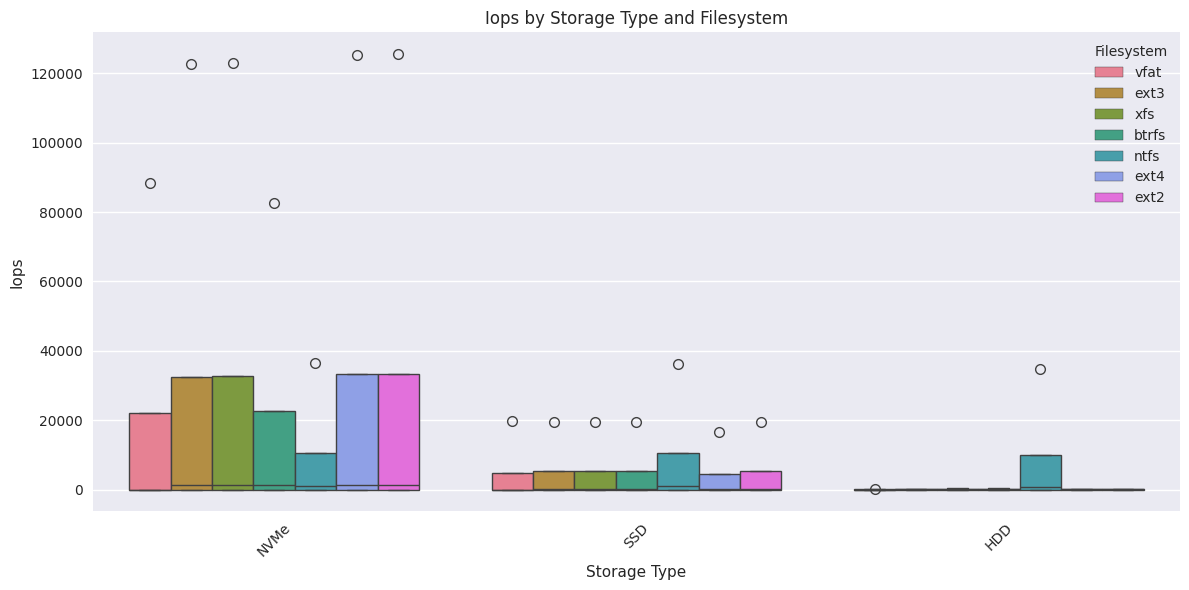

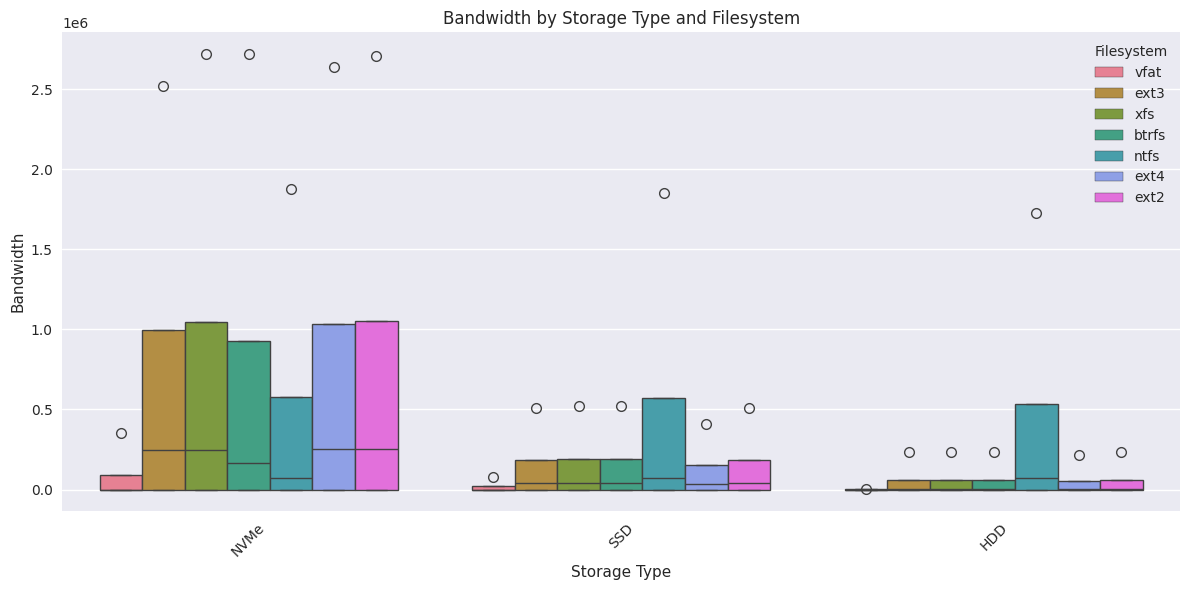

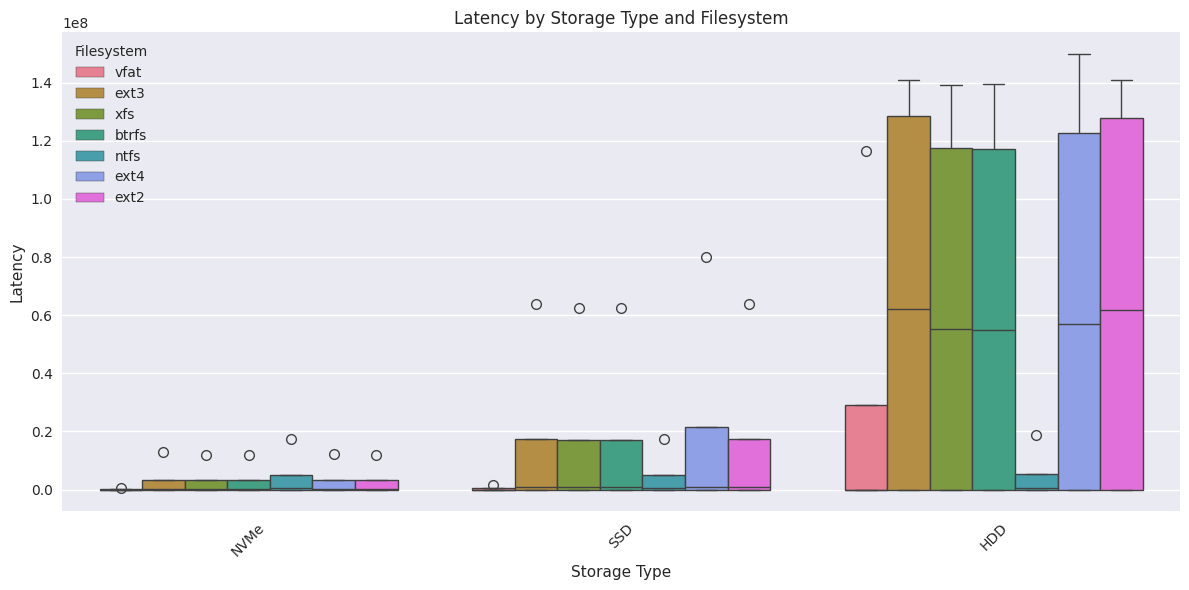

In [5]:
def plot_storage_performance(df, metric):
    """Plot performance metrics by storage type."""
    plt.figure(figsize=(12, 6))
    
    # Create box plot
    sns.boxplot(data=df, x='storage_type', y=metric, hue='filesystem')
    
    plt.title(f'{metric.title()} by Storage Type and Filesystem')
    plt.xlabel('Storage Type')
    plt.ylabel(metric.title())
    plt.xticks(rotation=45)
    plt.legend(title='Filesystem')
    plt.tight_layout()
    plt.show()

# Plot performance metrics
for metric in ['iops', 'bandwidth', 'latency']:
    plot_storage_performance(df, metric)

## 4. Filesystem Comparison <a name="filesystem-analysis"></a>


IOPS Comparison:


filesystem                            btrfs           ext2           ext3           ext4          ntfs          vfat            xfs
storage_type test_type                                                                                                             
HDD          random_read         291.049988     259.577509     257.369935     281.408540  34873.486763    274.804210     290.429866
             random_write          0.000000       0.000000       0.000000       0.000000      0.000000      0.000000       0.000000
             sequential_read     229.262286     226.962930     226.837238     213.433380   1686.290655      0.000000     229.776731
             sequential_write      0.000000       0.000000       0.000000       0.000000      0.000000      0.000000       0.000000
NVMe         random_read       82617.081626  125547.892720  122554.464703  125367.766619  36343.269097  88323.450135  123014.547161
             random_write          0.000000       0.000000       0.000000       0.000000      0.000000      0.000000       0.000000
             sequential_read    2654.569021    2645.994832    2460.060060    2577.721838   1834.303627      0.000000    2656.290532
             sequential_write      0.000000       0.000000       0.000000       0.000000      0.000000      0.000000       0.000000
SSD          random_read       19544.024454   19586.371787   19533.830104   16600.848585  36272.865643  19611.281514   19507.664831
             random_write          0.000000       0.000000       0.000000       0.000000      0.000000      0.000000       0.000000
             sequential_read     510.595861     499.634057     499.695010     399.804783   1809.986743      0.000000     510.659519
             sequential_write      0.000000       0.000000       0.000000       0.000000      0.000000      0.000000       0.000000

<Figure size 1200x600 with 0 Axes>

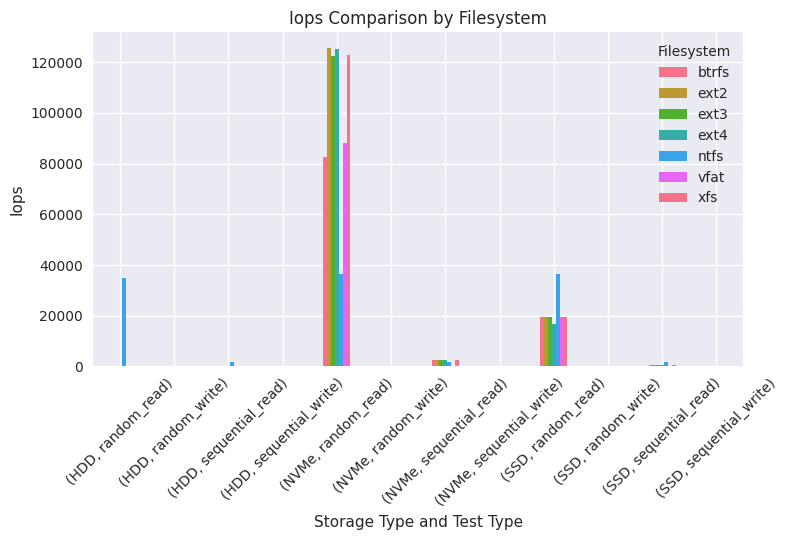


BANDWIDTH Comparison:


filesystem                         btrfs       ext2       ext3       ext4       ntfs      vfat        xfs
storage_type test_type                                                                                   
HDD          random_read          1164.0     1038.0     1029.0     1125.0   139493.0    1099.0     1161.0
             random_write            0.0        0.0        0.0        0.0        0.0       0.0        0.0
             sequential_read    234764.0   232410.0   232281.0   218555.0  1726761.0       0.0   235291.0
             sequential_write        0.0        0.0        0.0        0.0        0.0       0.0        0.0
NVMe         random_read        330468.0   502191.0   490217.0   501471.0   145373.0  353293.0   492058.0
             random_write            0.0        0.0        0.0        0.0        0.0       0.0        0.0
             sequential_read   2718278.0  2709498.0  2519101.0  2639587.0  1878326.0       0.0  2720041.0
             sequential_write        0.0        0.0        0.0        0.0        0.0       0.0        0.0
SSD          random_read         78176.0    78345.0    78135.0    66403.0   145091.0   78445.0    78030.0
             random_write            0.0        0.0        0.0        0.0        0.0       0.0        0.0
             sequential_read    522850.0   511625.0   511687.0   409400.0  1853426.0       0.0   522915.0
             sequential_write        0.0        0.0        0.0        0.0        0.0       0.0        0.0

<Figure size 1200x600 with 0 Axes>

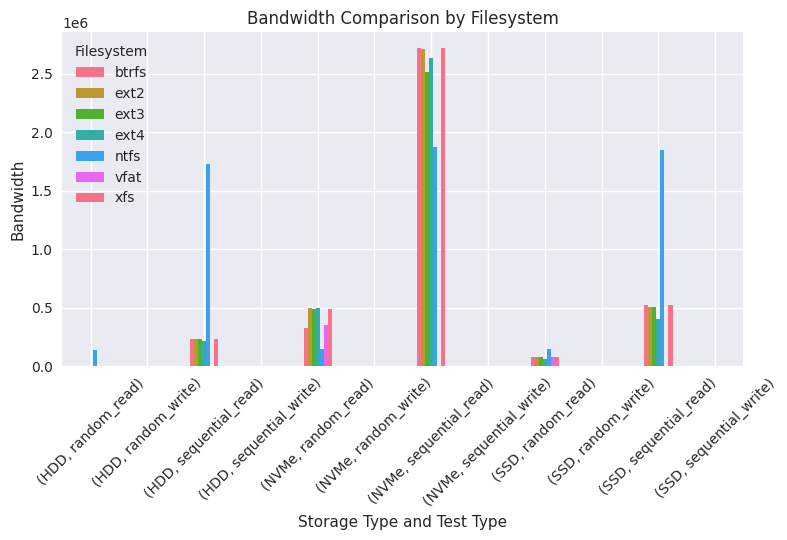


LATENCY Comparison:


filesystem                            btrfs          ext2          ext3          ext4          ntfs          vfat           xfs
storage_type test_type                                                                                                         
HDD          random_read       1.099335e+08  1.232628e+08  1.243215e+08  1.137028e+08  9.158244e+05  1.164325e+08  1.101695e+08
             random_write      0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
             sequential_read   1.394754e+08  1.408839e+08  1.409617e+08  1.498208e+08  1.878933e+07  0.000000e+00  1.391576e+08
             sequential_write  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
NVMe         random_read       3.864838e+05  2.540123e+05  2.602802e+05  2.544177e+05  8.791321e+05  3.616420e+05  2.592703e+05
             random_write      0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
             sequential_read   1.198030e+07  1.201364e+07  1.292395e+07  1.234481e+07  1.727433e+07  0.000000e+00  1.196540e+07
             sequential_write  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
SSD          random_read       1.635174e+06  1.631772e+06  1.636321e+06  1.925733e+06  8.806149e+05  1.630163e+06  1.638377e+06
             random_write      0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
             sequential_read   6.258500e+07  6.397019e+07  6.395002e+07  7.996131e+07  1.750670e+07  0.000000e+00  6.257917e+07
             sequential_write  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00

<Figure size 1200x600 with 0 Axes>

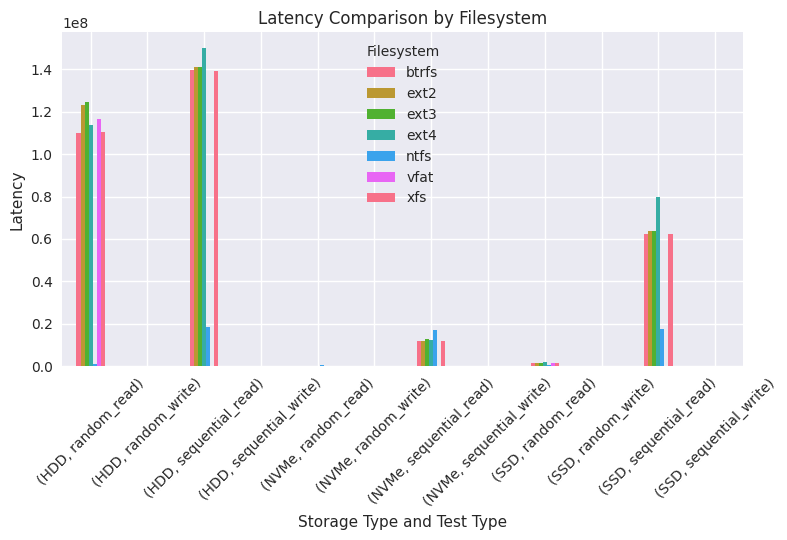

In [6]:
def analyze_filesystem_performance(df):
    """Analyze filesystem performance across different test types."""
    # Create pivot table for each metric
    metrics = ['iops', 'bandwidth', 'latency']
    
    for metric in metrics:
        pivot = pd.pivot_table(
            df,
            values=metric,
            index=['storage_type', 'test_type'],
            columns='filesystem',
            aggfunc='mean'
        )
        
        print(f"\n{metric.upper()} Comparison:")
        display(pivot)
        
        # Plot comparison
        plt.figure(figsize=(12, 6))
        pivot.plot(kind='bar')
        plt.title(f'{metric.title()} Comparison by Filesystem')
        plt.xlabel('Storage Type and Test Type')
        plt.ylabel(metric.title())
        plt.xticks(rotation=45)
        plt.legend(title='Filesystem')
        plt.tight_layout()
        plt.show()

analyze_filesystem_performance(df)

## 5. I/O Pattern Analysis <a name="io-analysis"></a>


I/O Pattern Statistics:


iops                               bandwidth                                     latency                                      
                      mean       std     min        max       mean         std     min        max         mean          std        min           max
test_type                                                                                                                                           
random_read       42426.36  47169.54  257.37  125547.89   169705.0   188678.13  1029.0   502191.0  33922463.32  53484424.55  254012.28  1.243215e+08
random_write          0.00      0.00    0.00       0.00        0.0        0.00     0.0        0.0         0.00         0.00       0.00  0.000000e+00
sequential_read    1041.52   1047.36    0.00    2656.29  1066514.1  1072498.11     0.0  2720041.0  55149690.04  55330240.55       0.00  1.498208e+08
sequential_write      0.00      0.00    0.00       0.00        0.0        0.00     0.0        0.0         0.00         0.00       0.00  0.000000e+00

/tmp/ipykernel_274006/2355957436.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0,0].set_xticklabels(axes[0,0].get_xticklabels(), rotation=45)
/tmp/ipykernel_274006/2355957436.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0,1].set_xticklabels(axes[0,1].get_xticklabels(), rotation=45)
/tmp/ipykernel_274006/2355957436.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1,0].set_xticklabels(axes[1,0].get_xticklabels(), rotation=45)


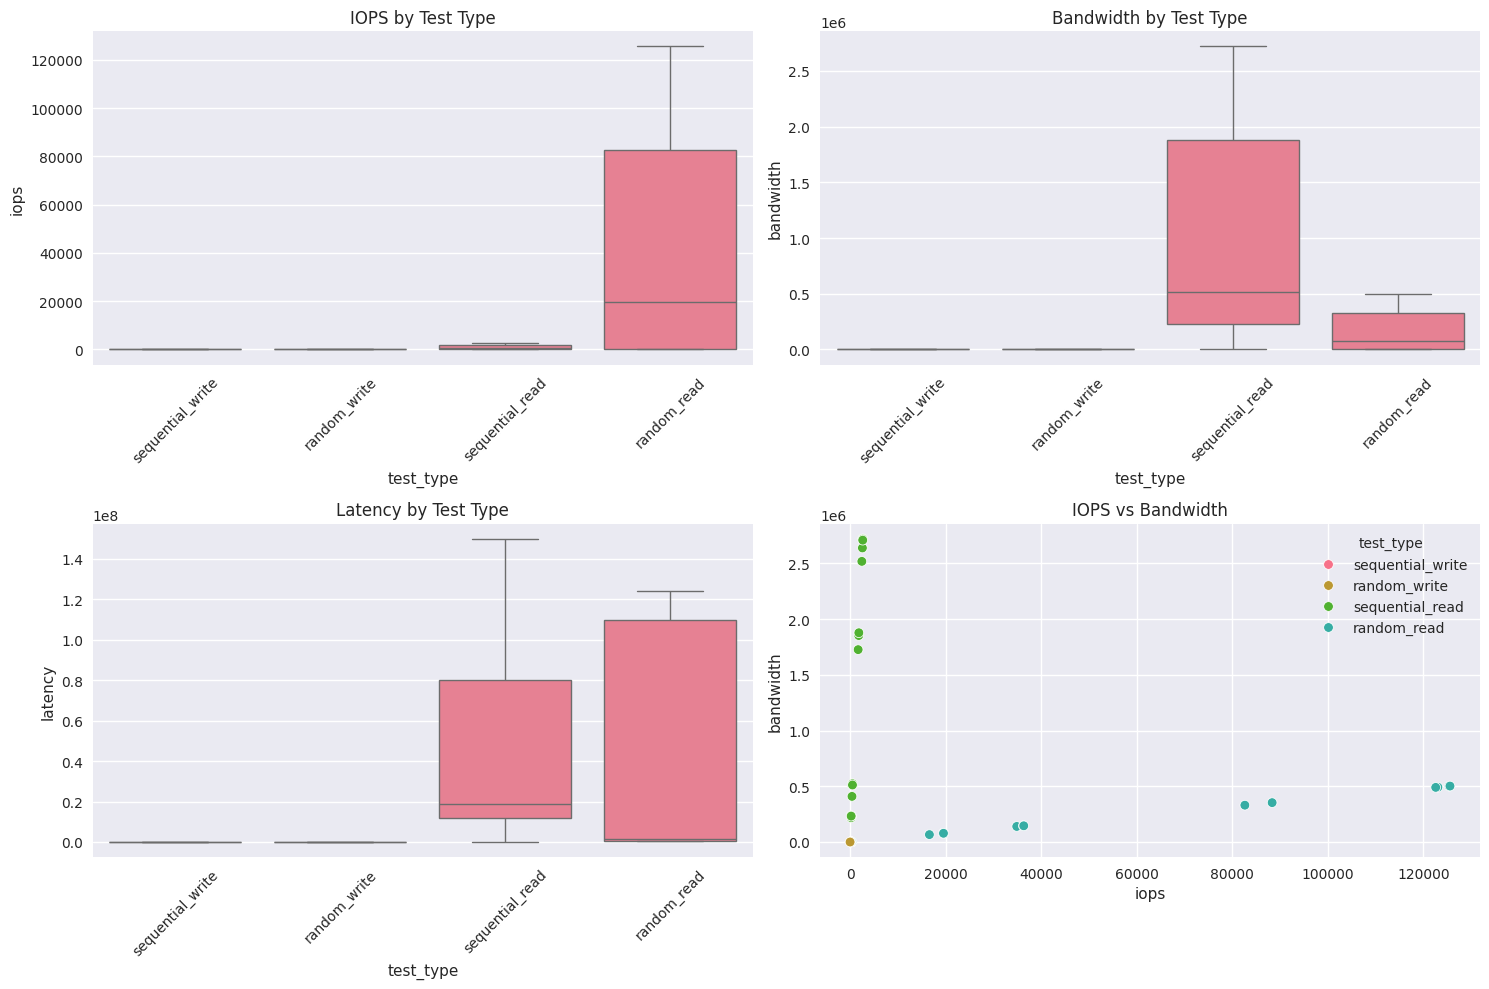

In [7]:
def analyze_io_patterns(df):
    """Analyze I/O patterns across different test types."""
    # Group by test type and calculate statistics
    io_stats = df.groupby('test_type').agg({
        'iops': ['mean', 'std', 'min', 'max'],
        'bandwidth': ['mean', 'std', 'min', 'max'],
        'latency': ['mean', 'std', 'min', 'max']
    }).round(2)
    
    print("\nI/O Pattern Statistics:")
    display(io_stats)
    
    # Plot I/O patterns
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # IOPS by test type
    sns.boxplot(data=df, x='test_type', y='iops', ax=axes[0,0])
    axes[0,0].set_title('IOPS by Test Type')
    axes[0,0].set_xticklabels(axes[0,0].get_xticklabels(), rotation=45)
    
    # Bandwidth by test type
    sns.boxplot(data=df, x='test_type', y='bandwidth', ax=axes[0,1])
    axes[0,1].set_title('Bandwidth by Test Type')
    axes[0,1].set_xticklabels(axes[0,1].get_xticklabels(), rotation=45)
    
    # Latency by test type
    sns.boxplot(data=df, x='test_type', y='latency', ax=axes[1,0])
    axes[1,0].set_title('Latency by Test Type')
    axes[1,0].set_xticklabels(axes[1,0].get_xticklabels(), rotation=45)
    
    # IOPS vs Bandwidth scatter
    sns.scatterplot(data=df, x='iops', y='bandwidth', hue='test_type', ax=axes[1,1])
    axes[1,1].set_title('IOPS vs Bandwidth')
    
    plt.tight_layout()
    plt.show()

analyze_io_patterns(df)

## 6. Resource Utilization <a name="resource-analysis"></a>

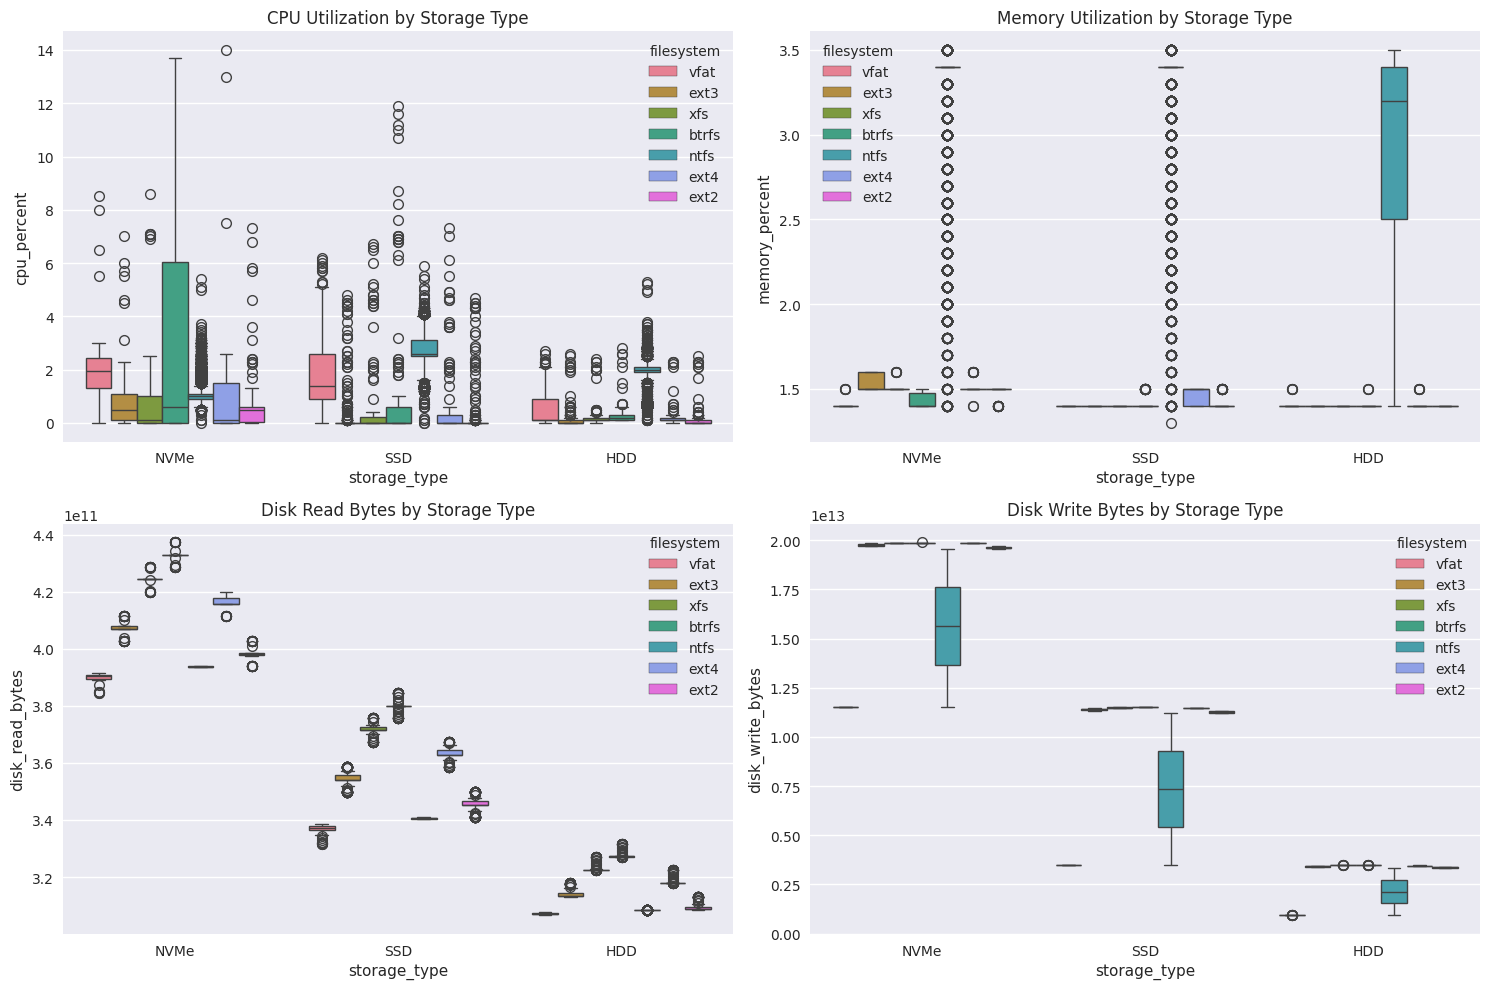

In [8]:
def analyze_resource_utilization(df):
    """Analyze system resource utilization during benchmarks."""
    # Extract monitoring data
    monitor_data = []
    for _, row in df.iterrows():
        for stat in row['monitor_data']['stats']:
            monitor_data.append({
                'storage_type': row['storage_type'],
                'filesystem': row['filesystem'],
                'test_type': row['test_type'],
                'timestamp': stat['timestamp'],
                'cpu_percent': stat['cpu_percent'],
                'memory_percent': stat['memory_percent'],
                'disk_read_bytes': stat['disk_read_bytes'],
                'disk_write_bytes': stat['disk_write_bytes']
            })
    
    monitor_df = pd.DataFrame(monitor_data)
    
    # Plot resource utilization
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # CPU utilization
    sns.boxplot(data=monitor_df, x='storage_type', y='cpu_percent', hue='filesystem', ax=axes[0,0])
    axes[0,0].set_title('CPU Utilization by Storage Type')
    
    # Memory utilization
    sns.boxplot(data=monitor_df, x='storage_type', y='memory_percent', hue='filesystem', ax=axes[0,1])
    axes[0,1].set_title('Memory Utilization by Storage Type')
    
    # Disk read bytes
    sns.boxplot(data=monitor_df, x='storage_type', y='disk_read_bytes', hue='filesystem', ax=axes[1,0])
    axes[1,0].set_title('Disk Read Bytes by Storage Type')
    
    # Disk write bytes
    sns.boxplot(data=monitor_df, x='storage_type', y='disk_write_bytes', hue='filesystem', ax=axes[1,1])
    axes[1,1].set_title('Disk Write Bytes by Storage Type')
    
    plt.tight_layout()
    plt.show()

analyze_resource_utilization(df)

## 7. Statistical Analysis <a name="statistical-analysis"></a>


ANOVA Test for IOPS:
Storage Type ANOVA: F-statistic = 6.07, p-value = 0.0035
Filesystem ANOVA: F-statistic = 0.04, p-value = 0.9998

Correlation Matrix for iops:


,iops,bandwidth,latency
iops,1.000000,0.054441,-0.174652
bandwidth,0.054441,1.000000,0.004696
latency,-0.174652,0.004696,1.000000


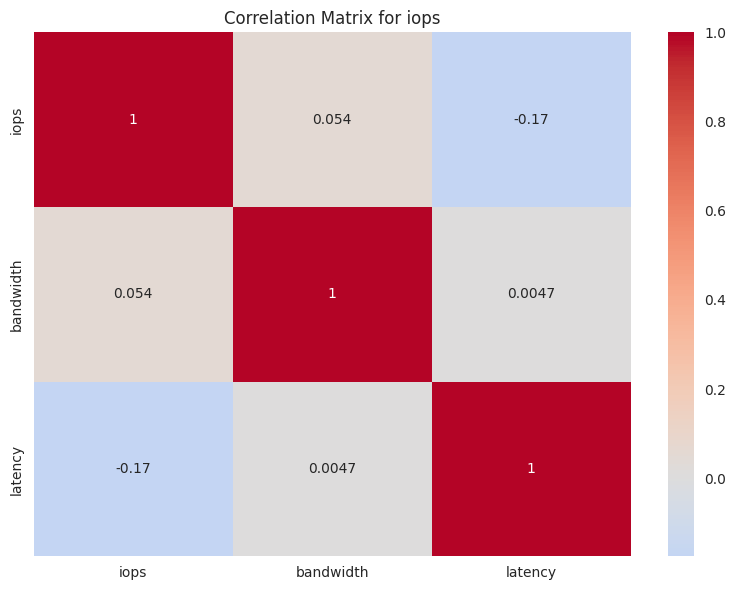


ANOVA Test for BANDWIDTH:
Storage Type ANOVA: F-statistic = 5.42, p-value = 0.0062
Filesystem ANOVA: F-statistic = 0.43, p-value = 0.8541

Correlation Matrix for bandwidth:


,iops,bandwidth,latency
iops,1.000000,0.054441,-0.174652
bandwidth,0.054441,1.000000,0.004696
latency,-0.174652,0.004696,1.000000


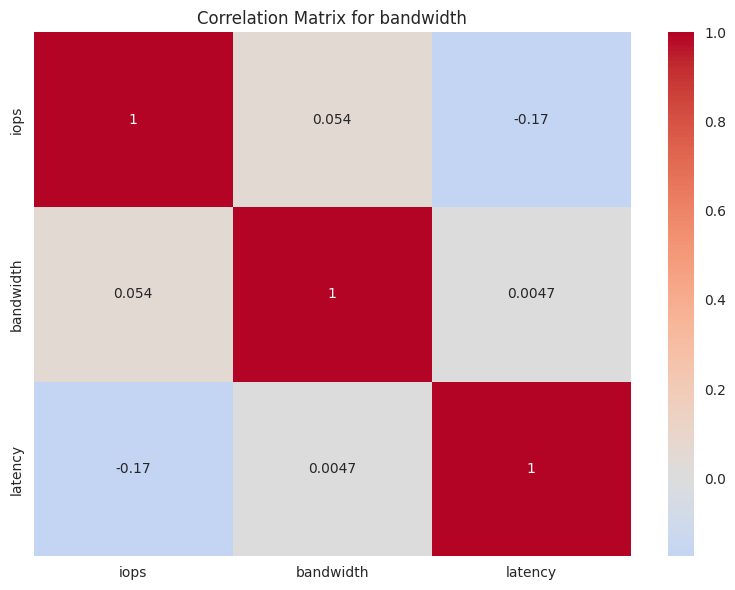


ANOVA Test for LATENCY:
Storage Type ANOVA: F-statistic = 11.34, p-value = 0.0000
Filesystem ANOVA: F-statistic = 0.64, p-value = 0.7017

Correlation Matrix for latency:


,iops,bandwidth,latency
iops,1.000000,0.054441,-0.174652
bandwidth,0.054441,1.000000,0.004696
latency,-0.174652,0.004696,1.000000


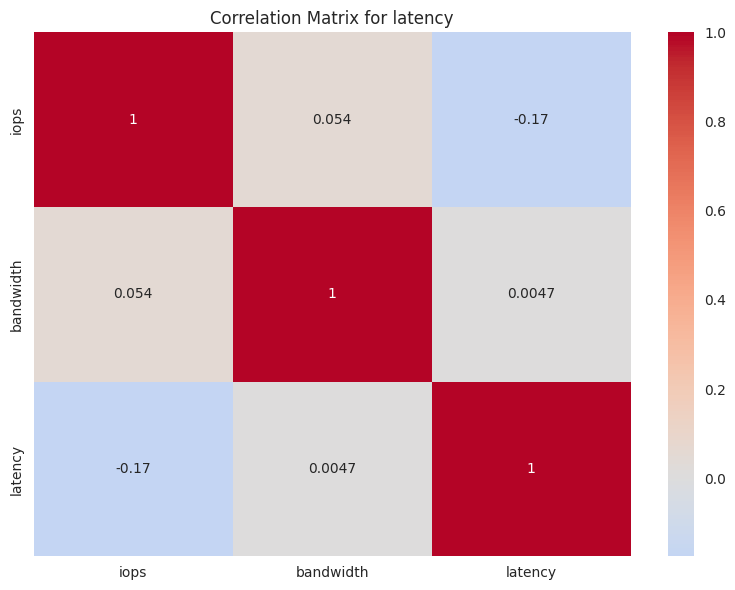

In [9]:
def perform_statistical_analysis(df):
    """Perform statistical analysis on benchmark results."""
    # ANOVA test for each metric
    metrics = ['iops', 'bandwidth', 'latency']
    
    for metric in metrics:
        print(f"\nANOVA Test for {metric.upper()}:")
        
        # Test by storage type
        storage_groups = [group for _, group in df.groupby('storage_type')[metric]]
        f_stat, p_val = stats.f_oneway(*storage_groups)
        print(f"Storage Type ANOVA: F-statistic = {f_stat:.2f}, p-value = {p_val:.4f}")
        
        # Test by filesystem
        fs_groups = [group for _, group in df.groupby('filesystem')[metric]]
        f_stat, p_val = stats.f_oneway(*fs_groups)
        print(f"Filesystem ANOVA: F-statistic = {f_stat:.2f}, p-value = {p_val:.4f}")
        
        # Correlation analysis
        corr_matrix = df[metrics].corr()
        print(f"\nCorrelation Matrix for {metric}:")
        display(corr_matrix)
        
        # Plot correlation heatmap
        plt.figure(figsize=(8, 6))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
        plt.title(f'Correlation Matrix for {metric}')
        plt.tight_layout()
        plt.show()

perform_statistical_analysis(df)

## 8. Comparative Analysis <a name="comparative-analysis"></a>


IOPS Comparison by Storage Type:


storage_type,HDD,NVMe,SSD
test_type,,,
random_read,5218.303830,100538.353152,21522.412417
random_write,0.000000,0.000000,0.000000
sequential_read,401.794746,2118.419987,604.339425
sequential_write,0.000000,0.000000,0.000000



IOPS Comparison by Filesystem:


filesystem,btrfs,ext2,ext3,ext4,ntfs,vfat,xfs
test_type,,,,,,,
random_read,34150.718689,48464.614005,47448.554914,47416.674581,35829.873834,36069.845286,47604.213953
random_write,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
sequential_read,1131.475723,1124.197273,1062.197436,1063.653334,1776.860342,0.000000,1132.242261
sequential_write,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


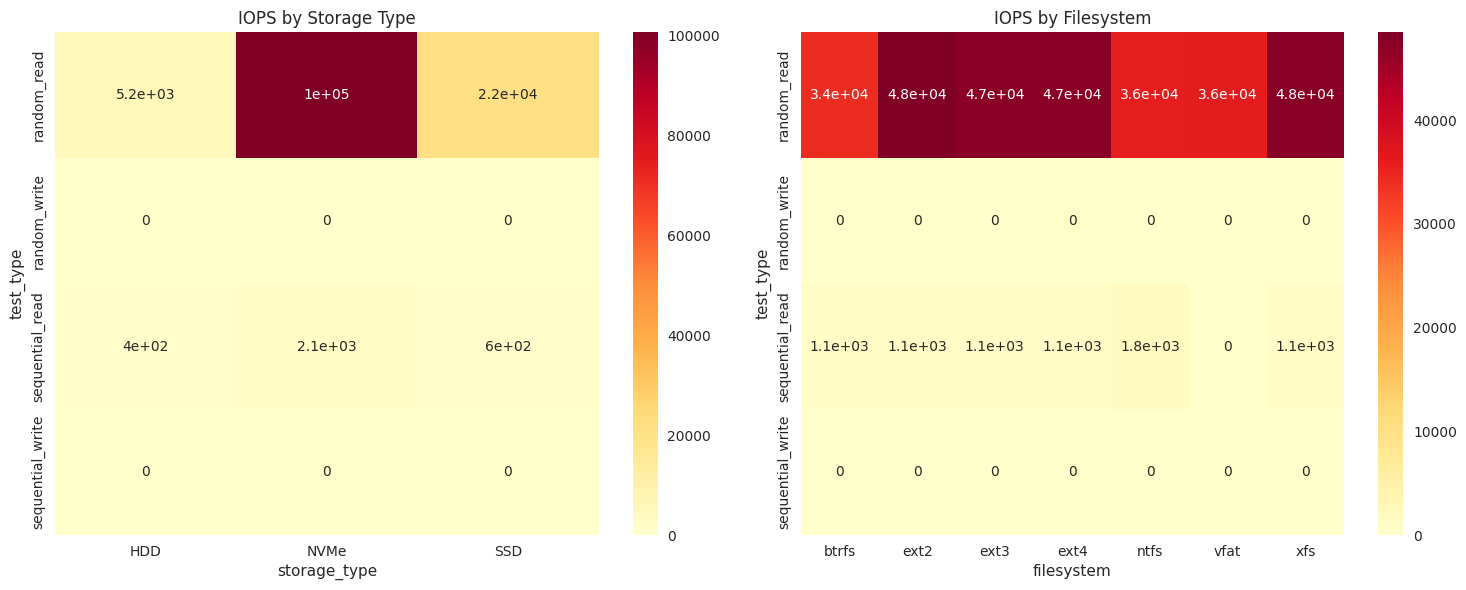


BANDWIDTH Comparison by Storage Type:


storage_type,HDD,NVMe,SSD
test_type,,,
random_read,20872.714286,4.021530e+05,86089.285714
random_write,0.000000,0.000000e+00,0.000000
sequential_read,411437.428571,2.169262e+06,618843.285714
sequential_write,0.000000,0.000000e+00,0.000000



BANDWIDTH Comparison by Filesystem:


filesystem,btrfs,ext2,ext3,ext4,ntfs,vfat,xfs
test_type,,,,,,,
random_read,1.366027e+05,1.938580e+05,1.897937e+05,1.896663e+05,1.433190e+05,144279.0,1.904163e+05
random_write,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00
sequential_read,1.158631e+06,1.151178e+06,1.087690e+06,1.089181e+06,1.819504e+06,0.0,1.159416e+06
sequential_write,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00


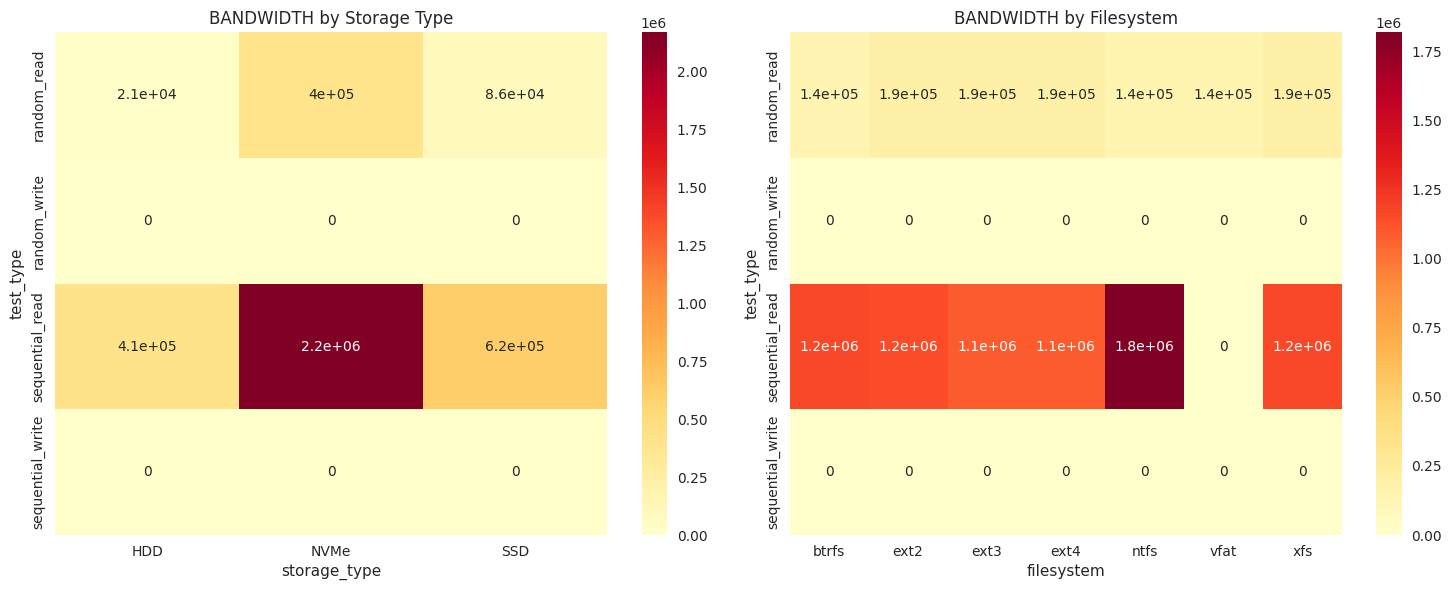


LATENCY Comparison by Storage Type:


storage_type,HDD,NVMe,SSD
test_type,,,
random_read,9.981976e+07,3.793198e+05,1.568308e+06
random_write,0.000000e+00,0.000000e+00,0.000000e+00
sequential_read,1.041555e+08,1.121463e+07,5.007891e+07
sequential_write,0.000000e+00,0.000000e+00,0.000000e+00



LATENCY Comparison by Filesystem:


filesystem,btrfs,ext2,ext3,ext4,ntfs,vfat,xfs
test_type,,,,,,,
random_read,3.731838e+07,4.171621e+07,4.207270e+07,3.862764e+07,8.918571e+05,3.947476e+07,3.735570e+07
random_write,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
sequential_read,7.134690e+07,7.228924e+07,7.261188e+07,8.070896e+07,1.785679e+07,0.000000e+00,7.123406e+07
sequential_write,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


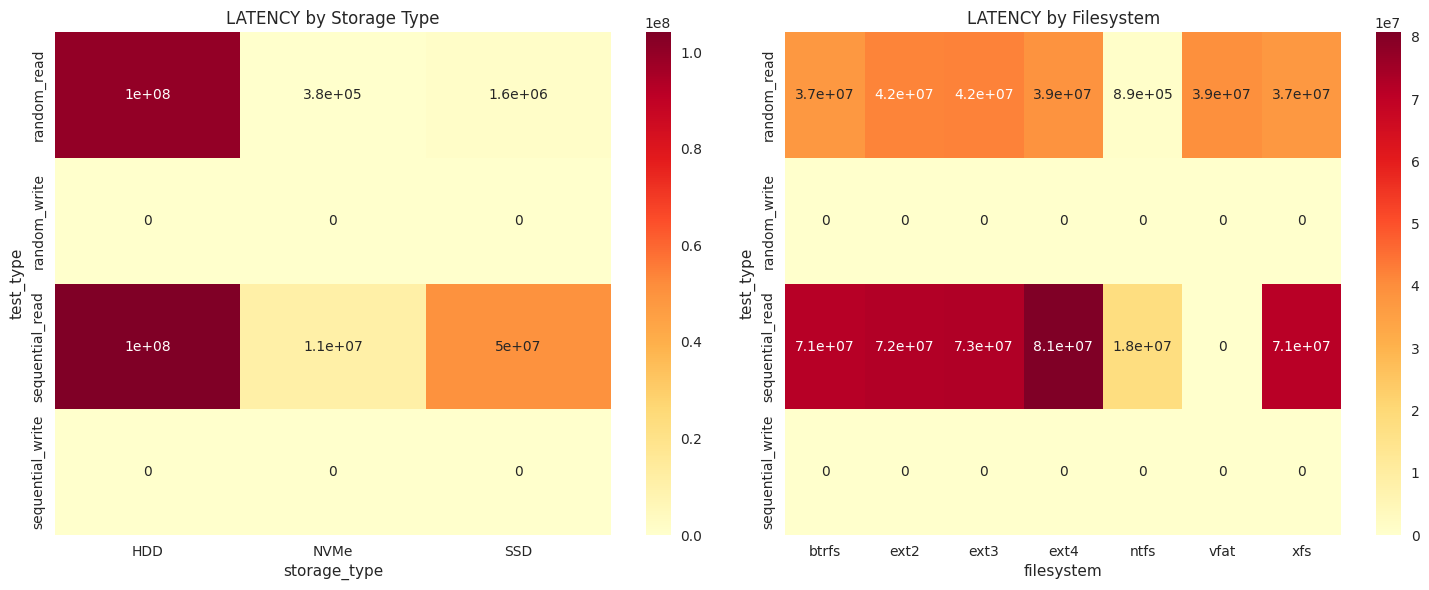

In [10]:
def perform_comparative_analysis(df):
    """Perform comparative analysis between different configurations."""
    # Create comparison matrix
    metrics = ['iops', 'bandwidth', 'latency']
    
    for metric in metrics:
        # Compare storage types
        storage_comparison = pd.pivot_table(
            df,
            values=metric,
            index='test_type',
            columns='storage_type',
            aggfunc='mean'
        )
        
        print(f"\n{metric.upper()} Comparison by Storage Type:")
        display(storage_comparison)
        
        # Compare filesystems
        fs_comparison = pd.pivot_table(
            df,
            values=metric,
            index='test_type',
            columns='filesystem',
            aggfunc='mean'
        )
        
        print(f"\n{metric.upper()} Comparison by Filesystem:")
        display(fs_comparison)
        
        # Plot comparison heatmaps
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        sns.heatmap(storage_comparison, annot=True, cmap='YlOrRd', ax=ax1)
        ax1.set_title(f'{metric.upper()} by Storage Type')
        
        sns.heatmap(fs_comparison, annot=True, cmap='YlOrRd', ax=ax2)
        ax2.set_title(f'{metric.upper()} by Filesystem')
        
        plt.tight_layout()
        plt.show()

perform_comparative_analysis(df)

## 9. Recommendations and Conclusions <a name="conclusions"></a>


Performance Scores and Recommendations:


performance_score      iops  bandwidth      latency
storage_type filesystem                                                     
HDD          btrfs                   -0.13    130.08   58982.00  62352218.81
             ext2                    -0.14    121.64   58362.00  66036683.71
             ext3                    -0.14    121.05   58327.50  66320794.95
             ext4                    -0.14    123.71   54920.00  65880881.21
             ntfs                     0.07   9139.94  466563.50   4926288.20
             vfat                    -0.06     68.70     274.75  29108118.51
             xfs                     -0.13    130.05   59113.00  62331767.75
NVMe         btrfs                    0.14  21317.91  762186.50   3091697.00
             ext2                     0.18  32048.47  802922.25   3066912.27
             ext3                     0.17  31253.63  752329.50   3296057.80
             ext4                     0.17  31986.37  785264.50   3149807.63
             ntfs                     0.08   9544.39  505924.75   4538366.42
             vfat                     0.07  22080.86   88323.25     90410.51
             xfs                      0.18  31417.71  803024.75   3056167.78
SSD          btrfs                   -0.00   5013.66  150256.50  16055044.37
             ext2                    -0.01   5021.50  147492.50  16400489.64
             ext3                    -0.01   5008.38  147455.50  16396584.39
             ext4                    -0.02   4250.16  118950.75  20471759.39
             ntfs                     0.08   9520.71  499629.25   4596827.56
             vfat                     0.01   4902.82   19611.25    407540.64
             xfs                     -0.00   5004.58  150236.25  16054386.58

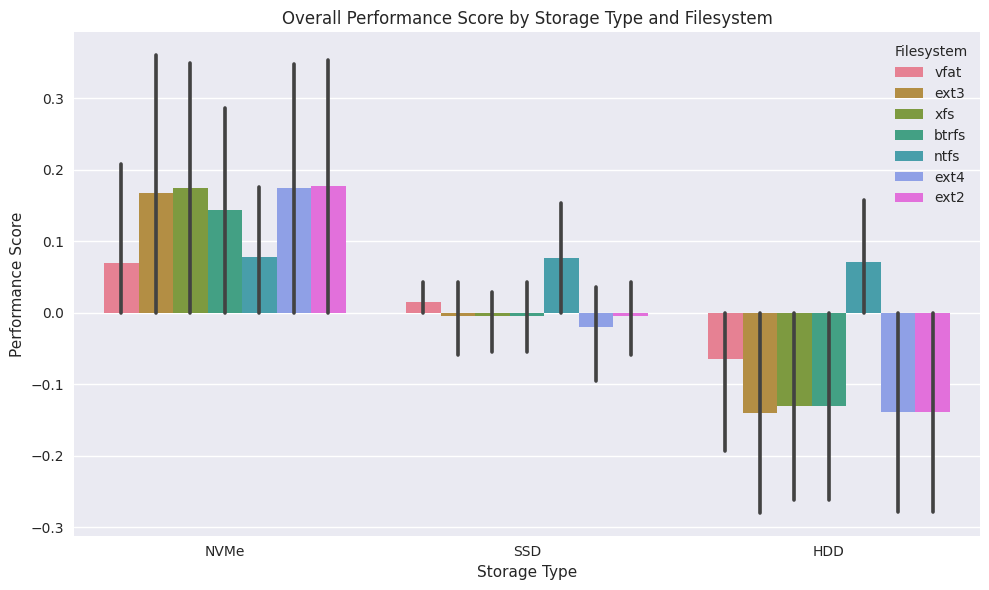

In [11]:
def generate_recommendations(df):
    """Generate recommendations based on benchmark results."""
    # Calculate performance scores
    df['performance_score'] = (
        df['iops'] / df['iops'].max() +
        df['bandwidth'] / df['bandwidth'].max() -
        df['latency'] / df['latency'].max()
    ) / 3
    
    # Group by storage type and filesystem
    recommendations = df.groupby(['storage_type', 'filesystem']).agg({
        'performance_score': 'mean',
        'iops': 'mean',
        'bandwidth': 'mean',
        'latency': 'mean'
    }).round(2)
    
    print("\nPerformance Scores and Recommendations:")
    display(recommendations)
    
    # Plot performance scores
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df, x='storage_type', y='performance_score', hue='filesystem')
    plt.title('Overall Performance Score by Storage Type and Filesystem')
    plt.xlabel('Storage Type')
    plt.ylabel('Performance Score')
    plt.legend(title='Filesystem')
    plt.tight_layout()
    plt.show()

generate_recommendations(df)